In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

class EdgePropagation(nn.Module):
    def __init__(self, num_segments=64, n_channels=3, height=224, width=224, device='cpu'):
        super(EdgePropagation, self).__init__()
        
        self.num_segments = num_segments
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        self.convert_to_grayscale = torchvision.transforms.Grayscale(num_output_channels=1)

    def compute_gradient_map(self, x):
        # Sobel kernels for single-channel input
        sobel_x = torch.tensor([[[[-1, 0, 1], 
                                  [-2, 0, 2], 
                                  [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], 
                                  [0, 0, 0], 
                                  [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)
        
        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2) + 1e-8)
        return grad_map

    def initialize_segmentation(self, batch_size):
        # Initialize segmentation mask with grid-based segments
        num_rows = int(math.sqrt(self.num_segments * self.H / self.W))
        num_cols = int(math.ceil(self.num_segments / num_rows))

        segment_height = self.H // num_rows
        segment_width = self.W // num_cols

        segmentation_masks = []
        for _ in range(batch_size):
            mask = torch.zeros((self.H, self.W), dtype=torch.long, device=self.device)
            label = 0
            for i in range(num_rows):
                for j in range(num_cols):
                    y_start = i * segment_height
                    y_end = (i + 1) * segment_height if i < num_rows -1 else self.H
                    x_start = j * segment_width
                    x_end = (j + 1) * segment_width if j < num_cols -1 else self.W
                    mask[y_start:y_end, x_start:x_end] = label
                    label += 1
            segmentation_masks.append(mask)
        segmentation_masks = torch.stack(segmentation_masks, dim=0)
        return segmentation_masks

    def propagate_boundaries(self, segmentation_masks, grad_map, num_iters=10):
        """
        Move boundaries along edges in the gradient map,
        in the direction where the gradient declines the least.
        """
        B, H, W = segmentation_masks.shape
        for _ in range(num_iters):
            # For each batch
            for b in range(B):
                mask = segmentation_masks[b]
                grad = grad_map[b, 0]
                # Get boundary pixels
                boundary = self.get_boundary(mask)
                boundary_indices = boundary.nonzero(as_tuple=False)
                # Create a copy to update boundaries
                new_mask = mask.clone()
                for idx in boundary_indices:
                    y, x = idx
                    label = mask[y, x]
                    # Get neighboring pixels
                    neighbors = self.get_neighbors(y, x, H, W)
                    min_grad = grad[y, x]
                    min_pos = (y, x)
                    min_label = label
                    for ny, nx in neighbors:
                        neighbor_label = mask[ny, nx]
                        if neighbor_label != label:
                            # Check if moving the boundary to (ny, nx) decreases the gradient
                            if grad[ny, nx] < min_grad:
                                min_grad = grad[ny, nx]
                                min_pos = (ny, nx)
                                min_label = neighbor_label
                    # Move the boundary pixel if a better position is found
                    if min_pos != (y, x):
                        new_mask[y, x] = min_label
                segmentation_masks[b] = new_mask
        return segmentation_masks

    def get_boundary(self, mask):
        # Compute boundary of the segmentation mask
        # Boundary pixels are those that have at least one neighbor with a different label
        H, W = mask.shape
        boundary = torch.zeros_like(mask, dtype=torch.bool)
        shifts = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dy, dx in shifts:
            shifted_mask = torch.roll(mask, shifts=(dy, dx), dims=(0, 1))
            boundary |= (shifted_mask != mask)
        return boundary

    def get_neighbors(self, y, x, H, W):
        # Return valid neighboring positions
        neighbors = []
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < H and 0 <= nx < W:
                neighbors.append((ny, nx))
        return neighbors

    def forward(self, x):
        B, C_in, H, W = x.shape
        
        if C_in == 3:
            grayscale_image = self.convert_to_grayscale(x)
        else:
            grayscale_image = x
        
        # Compute the gradient map from grayscale image
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Initialize segmentation masks
        segmentation_masks = self.initialize_segmentation(B)
        
        # Propagate boundaries along edges in gradient map
        segmentation_masks = self.propagate_boundaries(segmentation_masks, grad_map)
        
        return grad_map, segmentation_masks


In [8]:
# Initialize the model
model = EdgePropagation(num_segments=64, n_channels=3, height=224, width=224, device='cpu')

# Input image tensor of shape (batch_size, channels, height, width)
input_image = torch.randn(1, 3, 224, 224)

# Forward pass
grad_map, segmentation_masks = model(input_image)

# grad_map shape: (batch_size, 1, height, width)
# segmentation_masks shape: (batch_size, height, width)


In [9]:
from skimage.morphology import thin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


cmap = mpl.colors.ListedColormap(torch.rand(256**2, 3).numpy())

def plot_segmentation_boundaries(image_np, output_mask, figsize=(15, 15)):
    """
    Plot the boundaries of the segmentation over the original image.
    Uses pixel comparison to detect boundaries and applies thinning.
    """
    output_mask_np = output_mask[0].cpu().numpy()

    # Find boundaries by comparing neighboring pixels
    boundaries = np.zeros_like(output_mask_np)
    boundaries[1:, :] = np.logical_or(boundaries[1:, :], output_mask_np[1:, :] != output_mask_np[:-1, :])  # Compare vertically
    boundaries[:, 1:] = np.logical_or(boundaries[:, 1:], output_mask_np[:, 1:] != output_mask_np[:, :-1])  # Compare horizontally

    # Apply thinning to ensure boundaries are only 1 pixel wide
    boundaries = thin(boundaries)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(image_np)

    ax.contour(boundaries, colors='red', linewidths=0.7)

    ax.set_title('Image with Segmentation Boundaries (Thinned)')
    ax.axis('off')

    plt.show()
    
    
def plot_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask[0].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Superpixel Mask')
    plt.show()
    
def plot_gradient_map(grad_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(grad_map[0, 0].cpu().numpy(), cmap='gray')
    plt.colorbar()
    plt.title('Gradient Map')
    plt.show()



In [46]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images', split)
        self.ground_truth_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        gt_name = os.path.join(self.ground_truth_dir, self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = sio.loadmat(gt_name)
        ground_truth = gt_data['groundTruth'][0][0][0][0][1]

        
        #print(ground_truth)
        print(ground_truth.shape)
        # print(ground_truth[0, 0])
        # print(ground_truth[0, 0]['Segmentation'])
        segmentation = ground_truth
        
        if isinstance(segmentation, np.ndarray) and segmentation.shape == (1, 1):
            segmentation = segmentation[0, 0]
        
        segmentation = Image.fromarray(segmentation)
        segmentation = segmentation.resize((224, 224), Image.NEAREST)
        
        segmentation = np.array(segmentation, dtype=np.int64)

        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        return image, segmentation

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

dataset = BSDS500Dataset(root_dir=r'D:\Data\BSDS500\data', split='train', transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

random_idx = random.randint(0, len(dataset) - 1)

image, segmentation = dataset[random_idx]

(481, 321)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


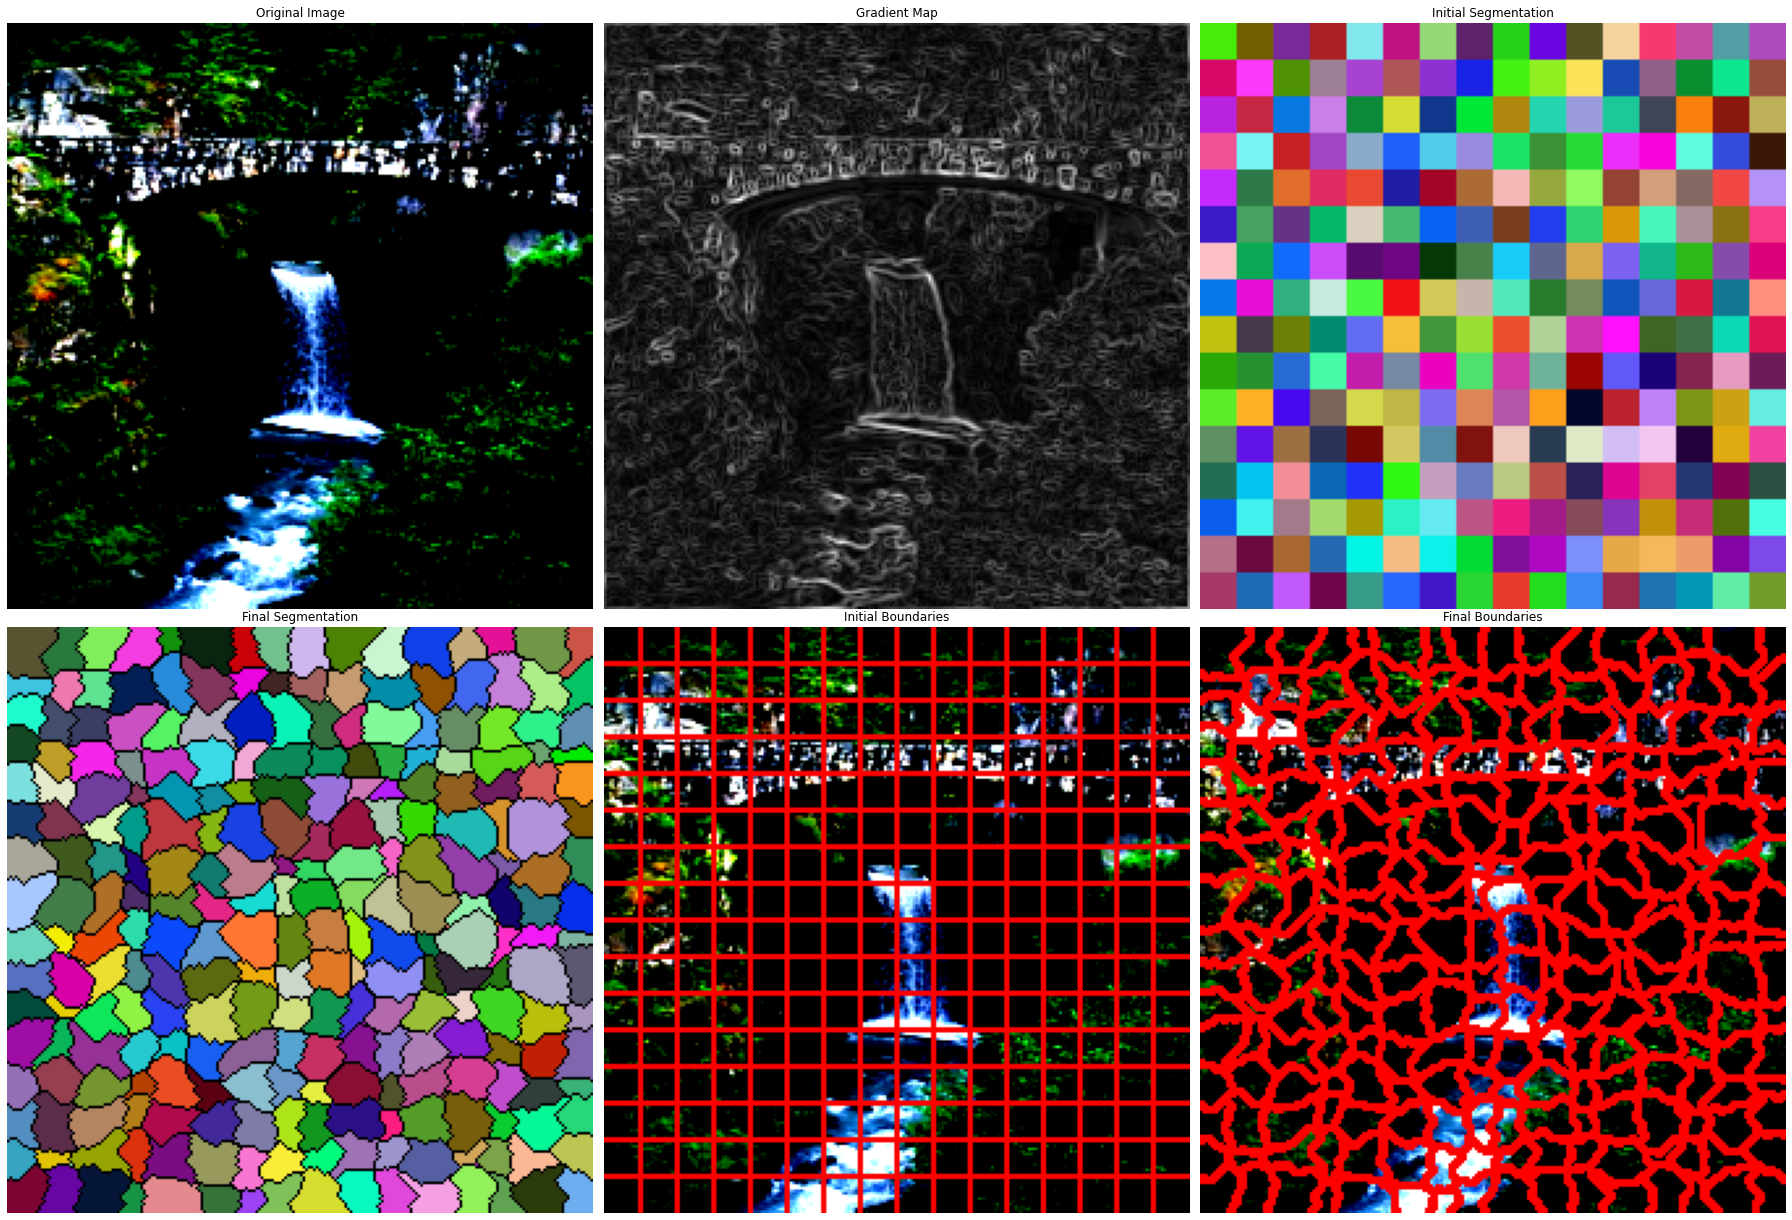

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class BoundaryPathFinder(nn.Module):
    def __init__(self, num_segments_row=8, num_segments_col=8, n_channels=3, height=224, width=224, device='cpu'):
        super(BoundaryPathFinder, self).__init__()
        
        self.num_segments_row = num_segments_row
        self.num_segments_col = num_segments_col
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        self.convert_to_grayscale = torchvision.transforms.Grayscale(num_output_channels=1)
    
    def compute_gradient_map(self, x):
        sobel_x = torch.tensor([[[[-1, 0, 1], 
                                  [-2, 0, 2], 
                                  [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], 
                                  [0, 0, 0], 
                                  [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)

        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2) + 1e-8)
        return grad_map.squeeze(0).squeeze(0).cpu().numpy()
    
    def initialize_grid(self):
        # Create initial grid segmentation
        segmentation_mask = np.zeros((self.H, self.W), dtype=np.int32)
        segment_height = self.H // self.num_segments_row
        segment_width = self.W // self.num_segments_col
        
        label = 1
        for i in range(self.num_segments_row):
            for j in range(self.num_segments_col):
                y_start = i * segment_height
                y_end = (i + 1) * segment_height if i < self.num_segments_row -1 else self.H
                x_start = j * segment_width
                x_end = (j + 1) * segment_width if j < self.num_segments_col -1 else self.W
                segmentation_mask[y_start:y_end, x_start:x_end] = label
                label += 1
        
        return segmentation_mask
    
    def adjust_boundaries(self, grad_map, segmentation_mask, band_width=5):
        """
        Adjust the boundary lines to align with the highest gradients.
        """
        H, W = segmentation_mask.shape
        
        # Initialize vertical and horizontal boundary positions
        vertical_boundaries_positions = []
        horizontal_boundaries_positions = []
        
        # Leftmost vertical boundary (x=0)
        vertical_boundaries_positions.append(np.zeros(H, dtype=int))
        
        # Vertical boundaries
        for i in range(1, self.num_segments_col):
            x = i * (W // self.num_segments_col)
            x = min(x, W - 1)
            path = self.find_optimal_vertical_path(grad_map, x, band_width)
            vertical_boundaries_positions.append(np.array(path))
        
        # Rightmost vertical boundary (x=W-1)
        vertical_boundaries_positions.append(np.full(H, W - 1, dtype=int))
        
        # Topmost horizontal boundary (y=0)
        horizontal_boundaries_positions.append(np.zeros(W, dtype=int))
        
        # Horizontal boundaries
        for i in range(1, self.num_segments_row):
            y = i * (H // self.num_segments_row)
            y = min(y, H - 1)
            path = self.find_optimal_horizontal_path(grad_map, y, band_width)
            horizontal_boundaries_positions.append(np.array(path))
        
        # Bottommost horizontal boundary (y=H-1)
        horizontal_boundaries_positions.append(np.full(W, H - 1, dtype=int))
        
        # Create boundary mask
        boundary_mask = np.zeros_like(segmentation_mask, dtype=bool)
        
        # Mark vertical boundaries
        for path in vertical_boundaries_positions[1:-1]:  # Exclude leftmost and rightmost boundaries
            for y, x in enumerate(path):
                boundary_mask[y, x] = True
        
        # Mark horizontal boundaries
        for path in horizontal_boundaries_positions[1:-1]:  # Exclude topmost and bottommost boundaries
            for x, y in enumerate(path):
                boundary_mask[y, x] = True
        
        # Use connected components labeling to get new segmentation mask
        from scipy.ndimage import label
        labeled_array, num_features = label(~boundary_mask)
        
        return labeled_array
    
    def find_optimal_vertical_path(self, grad_map, initial_x, band_width):
        """
        Find the optimal vertical path (top to bottom) around the initial_x position.
        """
        H, W = grad_map.shape
        band_positions = np.arange(-band_width, band_width + 1)
        x_indices = initial_x + band_positions
        x_indices = np.clip(x_indices, 0, W - 1)
        num_positions = len(x_indices)
        
        cost = np.full((H, num_positions), np.inf)
        path = np.zeros((H, num_positions), dtype=int)
        
        # Initialize the first row
        cost[0, :] = -grad_map[0, x_indices]
        
        for y in range(1, H):
            for idx in range(num_positions):
                x = x_indices[idx]
                min_cost = np.inf
                min_idx = -1
                for k in [-1, 0, 1]:
                    prev_idx = idx + k
                    if 0 <= prev_idx < num_positions:
                        c = cost[y - 1, prev_idx]
                        if c < min_cost:
                            min_cost = c
                            min_idx = prev_idx
                cost[y, idx] = min_cost - grad_map[y, x]
                path[y, idx] = min_idx
        
        # Backtrack to find the optimal path
        min_end_idx = np.argmin(cost[-1, :])
        optimal_path = []
        idx = min_end_idx
        for y in reversed(range(H)):
            x = x_indices[idx]
            optimal_path.append(x)
            idx = path[y, idx]
        optimal_path.reverse()
        return optimal_path
    
    def find_optimal_horizontal_path(self, grad_map, initial_y, band_width):
        """
        Find the optimal horizontal path (left to right) around the initial_y position.
        """
        H, W = grad_map.shape
        band_positions = np.arange(-band_width, band_width + 1)
        y_indices = initial_y + band_positions
        y_indices = np.clip(y_indices, 0, H - 1)
        num_positions = len(y_indices)
        
        cost = np.full((W, num_positions), np.inf)
        path = np.zeros((W, num_positions), dtype=int)
        
        # Initialize the first column
        cost[0, :] = -grad_map[y_indices, 0]
        
        for x in range(1, W):
            for idx in range(num_positions):
                y = y_indices[idx]
                min_cost = np.inf
                min_idx = -1
                for k in [-1, 0, 1]:
                    prev_idx = idx + k
                    if 0 <= prev_idx < num_positions:
                        c = cost[x - 1, prev_idx]
                        if c < min_cost:
                            min_cost = c
                            min_idx = prev_idx
                cost[x, idx] = min_cost - grad_map[y, x]
                path[x, idx] = min_idx
        
        # Backtrack to find the optimal path
        min_end_idx = np.argmin(cost[-1, :])
        optimal_path = []
        idx = min_end_idx
        for x in reversed(range(W)):
            y = y_indices[idx]
            optimal_path.append(y)
            idx = path[x, idx]
        optimal_path.reverse()
        return optimal_path
    
    def forward(self, x):
        B, C_in, H, W = x.shape
        assert B == 1, "Batch size must be 1."
        if C_in == 3:
            grayscale_image = self.convert_to_grayscale(x)
        else:
            grayscale_image = x
        
        # Compute gradient map
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Initialize grid segmentation
        segmentation_mask = self.initialize_grid()
        
        # Adjust boundaries to align with highest gradients
        new_segmentation_mask = self.adjust_boundaries(grad_map, segmentation_mask)
        
        return grad_map, segmentation_mask, new_segmentation_mask

# Visualization Function
def visualize_results(input_image, grad_map, initial_segmentation, final_segmentation):
    """
    Visualize the original image, gradient map, initial segmentation, and final segmentation.
    """
    # Convert tensors to numpy arrays
    input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    # Normalize gradient map for visualization
    grad_map_norm = (grad_map - grad_map.min()) / (grad_map.max() - grad_map.min())
    
    # Create color maps for segmentation masks
    initial_mask_color = color_segmentation(initial_segmentation)
    final_mask_color = color_segmentation(final_segmentation)
    
    # Overlay boundaries on the original image
    initial_boundary = find_boundaries(initial_segmentation)
    final_boundary = find_boundaries(final_segmentation)
    overlay_initial = input_image_np.copy()
    overlay_initial[initial_boundary] = [1.0, 0, 0]  # Red color for boundaries
    overlay_final = input_image_np.copy()
    overlay_final[final_boundary] = [1.0, 0, 0]  # Red color for boundaries

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(25, 17))
    axes = axes.ravel()
    titles = ['Original Image', 'Gradient Map', 'Initial Segmentation', 
              'Final Segmentation', 'Initial Boundaries', 'Final Boundaries']
    images = [input_image_np, grad_map_norm, initial_mask_color, 
              final_mask_color, overlay_initial, overlay_final]

    for ax, img, title in zip(axes, images, titles):
        if img.ndim == 2 or img.shape[2] == 1:  # Grayscale
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def color_segmentation(segmentation_mask):
    """
    Assign random colors to each segment for visualization.
    """
    num_labels = segmentation_mask.max() + 1
    colors = np.random.rand(num_labels + 1, 3)
    colors[0] = 0  # Background color
    colored_mask = colors[segmentation_mask]
    return colored_mask

def find_boundaries(segmentation_mask):
    """
    Find boundaries in the segmentation mask.
    """
    from scipy.ndimage import generic_filter

    def boundary_func(values):
        center = values[4]
        return not np.all(values == center)

    footprint = np.array([[1,1,1],
                          [1,1,1],
                          [1,1,1]])
    boundaries = generic_filter(segmentation_mask, boundary_func, footprint=footprint)
    return boundaries.astype(bool)


device = "cpu"
input_image = image.to(device)

model = BoundaryPathFinder(num_segments_row=16, num_segments_col=16, n_channels=3, height=224, width=224, device=device)
grad_map, initial_segmentation, final_segmentation = model(input_image.unsqueeze(0))
visualize_results(input_image, grad_map, initial_segmentation, final_segmentation)
